# Applying Fake-Authentic Classifier Over Facebook Political Ads

In [17]:
!pip install spacy tqdm

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [18]:
!python -m spacy download en_core_web_lg

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [19]:
!pip install textblob

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [20]:
!pip install nltk

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [21]:
!pip install preprocessor

^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [22]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [23]:
!pip install wordcloud

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [24]:
!pip install xlrd

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [25]:
pd.__version__

'1.0.4'

In [26]:
!pip install openpyxl

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [27]:
!pip install gensim

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [28]:
!pip3 install tensorflow_hub

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [29]:
!pip install nltk
nltk.download('wordnet')

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Part 2: Supervised Learning~Developing a Fake-True Classifier 

In [1]:
import spacy 
import en_core_web_lg

#spacy.prefer_gpu()
nlp = en_core_web_lg.load()

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress bar")


import preprocessor
from textblob import TextBlob
import statistics
from typing import List


import scipy

import spacy
import nltk
import re

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

### Data

In [3]:
##DON'T RUN ALL CELLS AUTOMATICALLY, OR WE'LL UNDO THE PICKELED VECTORS!!!!

fake_df = pd.read_csv('Fake.csv')

In [ ]:
%time fake_df.shape

In [4]:
true_df = pd.read_csv("True.csv") 

In [33]:
#Transform 'Fake' and 'True' into Vectors
fake_vectors = fake_df['text'].progress_apply(lambda x: pd.Series(nlp(x).doc.vector.tolist()))

progress bar: 100%|██████████| 23481/23481 [35:49<00:00, 10.92it/s] 


In [34]:
true_vectors = true_df['text'].progress_apply(lambda x: pd.Series(nlp(x).doc.vector.tolist()))

progress bar: 100%|██████████| 21417/21417 [28:28<00:00, 12.54it/s] 


In [35]:
fake_vectors.to_pickle('fake_vectors.pickle')
true_vectors.to_pickle('true_vectors.pickle')

### Open Pickled Data

In [5]:
#Open pickled FAKE vectors from here.
##OKAY TO RUN ALL CELLS from here.
import pickle

with open('/storage/fake_vectors.pickle','rb') as pickle_fake_file:
    fake_vectors = pickle.load(pickle_fake_file)

In [6]:
#Open pickled true_vectors from here
with open('/storage/true_vectors.pickle','rb') as pickle_true_file:
    true_vectors = pickle.load(pickle_true_file)

In [7]:
#Need to assign values to vectors.
fake_vectors['y'] = 0
true_vectors['y'] = 1

In [8]:
#Need to assign values to original dataframe.
#Concatenate
true_df['y'] = 1
fake_df['y'] = 0

all_df= pd.concat([true_df, fake_df], ignore_index=True)

In [9]:
all_df

,title,text,subject,date,y
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [10]:
#Need to import library for Stop Words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#Clean text for real news 

def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>', "", text) #Remove html tag
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') #Return leftover urls
    text = re.sub(pattern, ' ', text) #includes pattern when the urls weren't removed from above
    #token = word_tokenize(text)
    words = [word for word in text.split(" ") if word.isalpha()]
    stop_words = set(stopwords.words("english"))
   # #Include additional noise words
    stop_words.add("not")
    stop_words.add("this")
    stop_words.add("would")
    stop_words.add("also")
    stop_words.add("could")
    stop_words.add("said")
    PS = PorterStemmer()
    words = [PS.stem(w) for w in words if w not in stop_words]
    words = ' '.join(words)
    return words
    return stop_words

In [12]:
clean_text("Donald said You're FIRED")

'donald fire'

In [13]:
#Check the noise, or 'stop_words'
stop_words = set(stopwords.words('english'))
print(stop_words)

{'than', 'same', 'now', "didn't", "she's", 'my', "isn't", 'very', 'has', 'below', 'being', 'been', 'shan', 'needn', 'an', 'from', 'him', 't', 'her', 'who', 'not', 'at', 'it', 'on', "shouldn't", 'you', 'but', 'further', 'don', 'were', 'again', 'such', 'yours', 'a', 'his', 'our', 'then', 'this', 'd', "hadn't", 'any', "aren't", "shan't", 'wouldn', 'that', "hasn't", 'can', 'be', 'just', 'why', 'over', "you'd", 'other', "it's", 'hers', 'and', 'didn', 'aren', 'they', 'each', 'to', 'won', 'when', 'so', 'them', "haven't", 'through', 'himself', 'mightn', 'here', 'off', 'have', 'wasn', 'most', 'once', 'if', 'she', 'your', 'those', 'until', 'above', 'is', 'weren', 'no', 'both', 'will', 'ain', 'myself', 'only', 'into', 'its', 'did', 'had', 'themselves', "doesn't", 'in', 'the', "couldn't", 'yourself', 'isn', 'own', 'where', 'before', 'whom', 'am', 'haven', 'hadn', 'how', 'm', 'having', 'should', 'by', 'does', 'itself', 'ours', 'these', "you'll", "mightn't", 'doesn', 'yourselves', 'or', 'there', "mu

In [14]:
print(all_df['text'].apply(clean_text))

0        washington head conserv republican faction vot...
1        washington transgend peopl allow first time en...
2        washington special counsel investig link russi...
3        washington trump campaign advis georg papadopo...
4        presid donald trump call postal servic friday ...
                               ...                        
44893    centuri wire say report earlier unlik mishap t...
44894    centuri wire say familiar whenev disput chang ...
44895    patrick henningsen centuri wirerememb obama ad...
44896    centuri wire say al jazeera america go histori...
44897    centuri wire say predict new year look new hos...
Name: text, Length: 44898, dtype: object


In [15]:
# Let's take a look at the updated text
all_df['updated_text'] = all_df['text'].apply(clean_text)

In [16]:
all_df[['updated_text', 'text']]

,updated_text,text
0,washington head conserv republican faction vot...,WASHINGTON (Reuters) - The head of a conservat...
1,washington transgend peopl allow first time en...,WASHINGTON (Reuters) - Transgender people will...
2,washington special counsel investig link russi...,WASHINGTON (Reuters) - The special counsel inv...
3,washington trump campaign advis georg papadopo...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,presid donald trump call postal servic friday ...,SEATTLE/WASHINGTON (Reuters) - President Donal...
...,...,...
44893,centuri wire say report earlier unlik mishap t...,21st Century Wire says As 21WIRE reported earl...
44894,centuri wire say familiar whenev disput chang ...,21st Century Wire says It s a familiar theme. ...
44895,patrick henningsen centuri wirerememb obama ad...,Patrick Henningsen 21st Century WireRemember ...
44896,centuri wire say al jazeera america go histori...,21st Century Wire says Al Jazeera America will...


In [17]:
from collections import Counter

c = Counter()

ignore_this = all_df['updated_text'].apply(lambda row: c.update(row.split(" ")))

In [18]:
top_words = c.most_common(100)
top_words

[('trump', 102168),
 ('presid', 48106),
 ('state', 46619),
 ('peopl', 34875),
 ('republican', 34816),
 ('one', 34268),
 ('say', 30570),
 ('new', 30513),
 ('like', 28222),
 ('donald', 27063),
 ('democrat', 24948),
 ('unit', 24743),
 ('govern', 24724),
 ('hous', 24673),
 ('call', 23770),
 ('nation', 23665),
 ('told', 23203),
 ('support', 22745),
 ('make', 22692),
 ('go', 22408),
 ('report', 21961),
 ('clinton', 21918),
 ('obama', 21904),
 ('white', 21892),
 ('time', 20909),
 ('last', 20681),
 ('american', 20642),
 ('year', 20287),
 ('get', 20121),
 ('senat', 20017),
 ('use', 19858),
 ('includ', 19463),
 ('two', 19337),
 ('offici', 18984),
 ('want', 18751),
 ('take', 18538),
 ('campaign', 18196),
 ('polit', 18154),
 ('vote', 18108),
 ('elect', 17988),
 ('even', 17976),
 ('former', 17596),
 ('parti', 17574),
 ('news', 17499),
 ('first', 17437),
 ('work', 17236),
 ('right', 16753),
 ('countri', 16715),
 ('secur', 16100),
 ('mani', 15934),
 ('washington', 15318),
 ('group', 15209),
 ('back',

## Visualizing Top Words
Plot the top 100 words identified within the fake and real news datasets after identifying 'noise words' and performing another round of cleaning in pre-processing.

Contrast wordlcloud in "fake_df" with wordcloud in "true_df".

### Observation: The following emerged as the "Top 100" words. Although we ran a function to remove 'Stop Words', let's flag noise words.
Trump, said,state', 
'peopl', 
 'republican','one', 'also', 'say', 'new','like','donald', 'democrat', 'unit', 'govern', 
 'hous', 
 'call', 'could','nation', 'told', 'support', 'make', 'go', 'report', 'clinton','obama','white','time', 'last', 'american', 'year', 'get', 
 'senat',
 'use',
 'includ', 
 'two', 
 'offici', 
 'want', 'take', 'campaign', 
 'polit',
 'vote', 'elect', 'even', 'former', 
 'parti', 
 'news', 'first',work',
 ('right', 16752),
 ('countri', 16715),
 ('secur', 16100),
 ('mani', 15934),
 ('washington', 15318),
 ('group', 15209),
 ('back', 15170),
 ('hillari', 15164),
 ('come', 14857),
 ('may', 14463),
 ('need', 14360),
 ('think', 14345),
 ('made', 14330),
 ('show', 14269),
 ('offic', 14168),
 ('sinc', 14041),
 ('presidenti', 13600),
 ('polic', 13567),
 ('us', 13564),
 ('ask', 13539),
 ('plan', 13350),
 ('law', 13240),
 ('court', 13165),
 ('accord', 12981),
 ('million', 12918),
 ('media', 12881),
 ('attack', 12699),
 ('imag', 12573),
 ('leader', 12563),
 ('help', 12492),
 ('tri', 12489),
 ('know', 12487),
 ('feder', 12085),
 ('north', 12051),
 ('day', 11930),
 ('foreign', 11759),
 ('member', 11691),
 ('forc', 11674),
 ('tax', 11627),
 ('public', 11602),
 ('percent', 11524),
 ('bill', 11468),
 ('administr', 11421),
 ('investig', 11267),
 ('see', 11118),
 ('talk', 11107),
 ('way', 11047),
 ('part', 10931),
 ('russian', 10712)] 

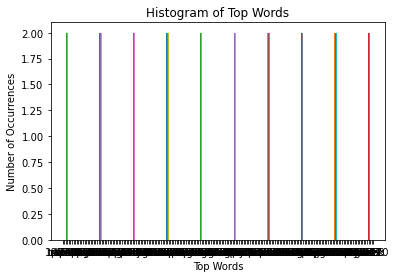

In [20]:
#Bar chart Plot number of times 'Top Words' listed
fig, ax = plt.subplots()

plt.hist(x, bins = 10)
ax.set_xlabel('Top Words')
ax.set_ylabel('Number of Occurrences')
ax.set_title(r'Barchart of Top Words')

plt.show()

### Feature: Number of Words ('num_words')
Include

In [21]:
#Stopwords feature
## Number of stopwords in the text for both True and Fake datasets b/c cleaned text (all_df) excludes
all_df["number_stopwords"] = true_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
all_df

,title,text,subject,date,y,updated_text,number_stopwords
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington head conserv republican faction vot...,282.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington transgend peopl allow first time en...,233.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington special counsel investig link russi...,184.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington trump campaign advis georg papadopo...,142.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,presid donald trump call postal servic friday ...,334.0
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,centuri wire say report earlier unlik mishap t...,NaN
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,centuri wire say familiar whenev disput chang ...,NaN
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen centuri wirerememb obama ad...,NaN
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,centuri wire say al jazeera america go histori...,NaN


In [22]:
## Number of words in the text ##
#df["num_words"] = df["text"].apply(lambda x: len(str(x).split()))
all_df["num_words"] = all_df["text"].apply(lambda x: len(str(x).split()))
all_df["num_words"]

0         749
1         624
2         457
3         376
4         852
         ... 
44893     522
44894     297
44895    4171
44896     456
44897     874
Name: num_words, Length: 44898, dtype: int64

In [23]:
all_df

,title,text,subject,date,y,updated_text,number_stopwords,num_words
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington head conserv republican faction vot...,282.0,749
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington transgend peopl allow first time en...,233.0,624
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington special counsel investig link russi...,184.0,457
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington trump campaign advis georg papadopo...,142.0,376
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,presid donald trump call postal servic friday ...,334.0,852
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,centuri wire say report earlier unlik mishap t...,NaN,522
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,centuri wire say familiar whenev disput chang ...,NaN,297
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen centuri wirerememb obama ad...,NaN,4171
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,centuri wire say al jazeera america go histori...,NaN,456


## Lemmatization

### Lemmatizer as Fake Criterion Feature: 
Identify Lemmas that occur the most in Fake-Real Classifier. Review if Lemma appears in Facebook 'message' and label as a feature of Fake-Real criterion.
Suspect that certain lemmas emerge consistently in fake news. 
*"Reporting", "Reporter", "Reports"
*"Supporter", "Supporting", "Supporter", "Support"
*Polling,polls, poll, pollster

These three lems "report", "support", and "poll" are used as both nouns and verbs. 

In [23]:
# Use 'Supporting'
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

word = "supporting" 
lem.lemmatize(word, "v")

stem.stem(word)

'support'

### Features of 'Support' Lemma
We can use the lemma to compare across the 'fake' and'real' news data sets to test whether there is a significant
difference in use of that particulare lemma in each category to note a distinction.  We would conduct a t-test bewteen the two classes: 'fake' and 'real'. Or we could run an F-test on the newly created feature.

If there is a distinction, that might be a better indicator for the Facebook Data set when distinguishing between 'fake' and 'real' stories in the political ads section.

#### Note: Convert Lemma 'support' into Feature to Count and Compare Across Fake and True datasets. Then if significant, add as feature in Facebook dataset.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html

In [24]:
# Use 'Supporters' as a noun
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

word = "supporters" 
lem.lemmatize(word, "n")

stem.stem(word)

'support'

In [25]:
# Use 'reporting'
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

word = "reporting" 
lem.lemmatize(word, "v")

stem.stem(word)

'report'

In [26]:
# Use 'supporting'
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

word = "supporting" 
lem.lemmatize(word, "v")

stem.stem(word)

'support'

In [27]:
# Use 'polling'
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

word = "polling" 
lem.lemmatize(word, "n")

stem.stem(word)

'poll'

### Feature Engineering
~Occurence of "Report" Lemma

In [28]:
import nltk 
w_tokenizer = nltk.tokenize.WhitespaceTokenizer() 
lemmatizer = nltk.stem.WordNetLemmatizer() 

def lemmatize_text(text): 
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)] 

all_df['support_lemma'] = all_df['text'].apply(lemmatize_text) 
df = pd.DataFrame(['this was cheesy', 'she likes these books', 'wow this is great'], columns=['text']) 
df['text_lemmatized'] = df.text.apply(lemmatize_text)

In [29]:
#We can use the lemma of 'support". 
#The same may be done with other highly used lemmas. 
sub ='supporting' 
all_df['support_lemma'] = all_df["text"].str.find(sub)
all_df['support_lemma']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
44893   -1
44894   -1
44895   -1
44896   -1
44897   -1
Name: support_lemma, Length: 44898, dtype: int64

In [30]:
sub ='supporting' 
fake_df['support_lemma'] = all_df["text"].str.find(sub)
fake_df['support_lemma']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
23476   -1
23477   -1
23478   -1
23479   -1
23480   -1
Name: support_lemma, Length: 23481, dtype: int64

In [31]:
true_df['support_lemma'] = all_df["text"].str.find(sub)
true_df['support_lemma'].head(10)

0   -1
1   -1
2   -1
3   -1
4   -1
5   -1
6   -1
7   -1
8   -1
9   -1
Name: support_lemma, dtype: int64

#### Test Feature Significance: T-Test

In [32]:
#T-test of support lemma across 'fake' and 'true' class
from scipy import stats
A = fake_df['support_lemma']
B = true_df['support_lemma']
ttest = stats.ttest_ind(A,B)
print ('t-test Support Feature', ttest)

#researchpy.ttest(x, y, group1_name= None, group2_name= None, equal_variances= True, paired= False, correction= None)
#print()

t-test Support Feature Ttest_indResult(statistic=-0.2526066001433395, pvalue=0.8005733856684583)


### Feature Lemma: 'Report'

In [33]:
def lemmatize_text_report(text): 
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)] 

all_df['report_lemma'] = all_df['text'].apply(lemmatize_text_report) 
#df = pd.DataFrame(['this was cheesy', 'she likes these books', 'wow this is great'], columns=['text']) 
df['text_lemmatized'] = df.text.apply(lemmatize_text_report)

In [34]:
all_df.head(15)

,title,text,subject,date,y,updated_text,number_stopwords,num_words,support_lemma,report_lemma
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington head conserv republican faction vot...,282.0,749,-1,"[WASHINGTON, (Reuters), -, The, head, of, a, c..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington transgend peopl allow first time en...,233.0,624,-1,"[WASHINGTON, (Reuters), -, Transgender, people..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington special counsel investig link russi...,184.0,457,-1,"[WASHINGTON, (Reuters), -, The, special, couns..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington trump campaign advis georg papadopo...,142.0,376,-1,"[WASHINGTON, (Reuters), -, Trump, campaign, ad..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,presid donald trump call postal servic friday ...,334.0,852,-1,"[SEATTLE/WASHINGTON, (Reuters), -, President, ..."
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1,west palm white hous friday set kick talk next...,218.0,599,-1,"[WEST, PALM, BEACH,, Fla./WASHINGTON, (Reuters..."
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1,west palm fla presid donald trump thursday bel...,214.0,538,-1,"[WEST, PALM, BEACH,, Fla, (Reuters), -, Presid..."
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,follow post verifi twitter account presid dona...,48.0,135,-1,"[The, following, statement, were, posted, to, ..."
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,follow post verifi twitter account presid dona...,35.0,100,-1,"[The, following, statement, were, posted, to, ..."
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",1,washington alabama secretari state john merril...,24.0,67,-1,"[WASHINGTON, (Reuters), -, Alabama, Secretary,..."


In [35]:
sub ='reporting' 
all_df['report_lemma'] = all_df["text"].str.find(sub)
all_df['report_lemma']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
44893   -1
44894   -1
44895   -1
44896   -1
44897   -1
Name: report_lemma, Length: 44898, dtype: int64

### Visual: Occurrences of Subjects Across Fake-True News

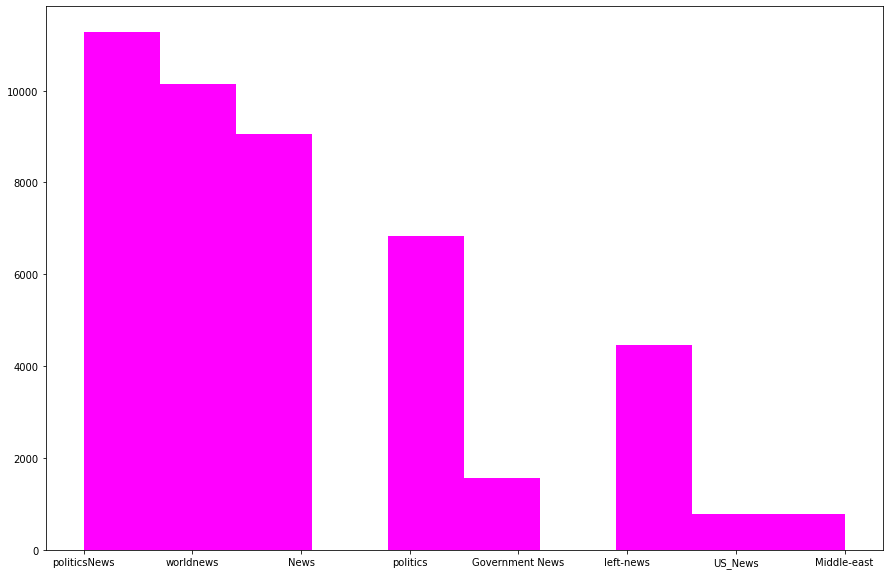

In [36]:
#Plot number of times 'subject' type listed
#fig, ax = plt.subplots()

plt.figure(figsize=(15,10))
plt.hist(all_df['subject'], bins = 10, color ='magenta')
ax.set_xlabel('Subjects')
ax.set_ylabel('Number of Occurrences')
ax.set_title(r'Histogram of Fake-True News Subjects')
#fig.tight_layout()

#plt.figure(figsize=(30,200))
plt.show()

## Method 1: Testing Bag of Words Model
We will compare and contrast results of using Random Forest Classifier with BOW method 

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_fake_real = CountVectorizer()
bag_of_words_fake_real = vectorizer_fake_real.fit_transform(all_df['updated_text'])

In [38]:
len(vectorizer_fake_real.get_feature_names())

59063

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
bag_of_words_fake_real.shape

(44898, 59063)

In [41]:
all_df['y'].shape

(44898,)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words_fake_real, all_df['y'],
                                                    random_state=42,
                                                    test_size=0.33)

In [43]:
y_train.shape

(30081,)

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc_bag = RandomForestClassifier()

rfc_bag.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
rfc_bag.score(X_train, y_train)

1.0

In [46]:
rfc_bag.score(X_test, y_test)

0.9684821488830397

### Word Cloud of Top 30 Words

###Visual:  Plot the Word Cloud

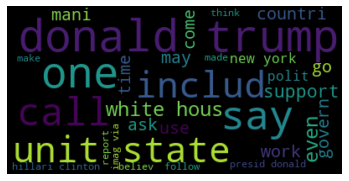

In [47]:
from wordcloud import WordCloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
#% matplotlib inline

#c:\intelpython3\lib\site-packages\matplotlib\__init__.py:

import warnings
warnings.filterwarnings("ignore")

text_wc_visual = " ".join(text for text in all_df.updated_text)
# Create and generate a word cloud image: wordcloud = WordCloud().generate(text)

wordcloud_BOW = WordCloud(max_words = 30).generate(text_wc_visual)
#parameters = WordCloud(width = 500, 
                      #contour_color = "purple",
                      #height= 300, 
                      #random_state = 21,
                      #max_words = 30,
                      #max_font_size =110).generate(top_words)
                    
plt.imshow(wordcloud_BOW, interpolation='bilinear')
plt.axis("off")
plt.show()                    

#### Word cloud for Fake words

In [48]:
#Fake data set -- clean it's text before showing in cloud
print(fake_df['text'].apply(clean_text))

0        donald trump wish american happi new year leav...
1        hous intellig committe chairman devin nune go ...
2        reveal former milwauke sheriff david consid ho...
3        christma donald trump announc back work follow...
4        pope franci use annual christma day messag reb...
                               ...                        
23476    centuri wire say report earlier unlik mishap t...
23477    centuri wire say familiar whenev disput chang ...
23478    patrick henningsen centuri wirerememb obama ad...
23479    centuri wire say al jazeera america go histori...
23480    centuri wire say predict new year look new hos...
Name: text, Length: 23481, dtype: object


In [49]:
# Let's take a look at the updated text for fake_df
fake_df['updated_text'] = fake_df['text'].apply(clean_text)

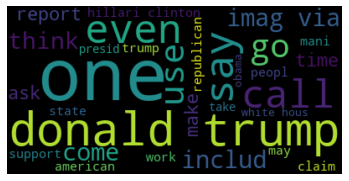

In [50]:
#Swap out 'text' for 'updated_text' for more accurate wordcloud on fake data
text_wc_visual_2 = " ".join(text for text in fake_df.updated_text)

wordcloud_BOW_2 = WordCloud(contour_color = "purple",max_words = 30).generate(text_wc_visual_2)
#Parameters to adjust = WordCloud(width = 500, 
                      #contour_color = "purple",
                      #height= 300, 
                      #random_state = 21,
                      #max_words = 30,
                      #max_font_size =110).generate(top_words)
                    
plt.imshow(wordcloud_BOW_2, interpolation='bilinear')
plt.axis("off")
plt.show() 

## METHOD TWO: spaCy Library -- Applying Text Vectors.


We will compare and contrast results of using Random Forest Classifier from BOW method with results from Text Vector method. 

In [51]:
all_vectors = pd.concat([fake_vectors, true_vectors], ignore_index=True)

In [52]:
#Method 2 requires that X and y be trained as X2_, and y2_
X2_train, X2_test, y2_train, y2_test = train_test_split(all_vectors.drop(columns=['y']), 
                                                    all_vectors['y'], 
                                                    random_state=42,
                                                    test_size=0.15)

In [53]:
#Run a random forest classifier on vectors
y2_train.shape

(38163,)

In [54]:
#Classifier for Method 2 using vectors
rfc_vectors = RandomForestClassifier(n_estimators=1000, max_depth=3, n_jobs=-1)

rfc_vectors.fit(X2_train, y2_train)

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=-1)

### Evaluation of Random Forest Classifier spaCy method

In [55]:
#Apply classifier to X2 and y2 training set and obtain 'Score'.
rfc_vectors.score(X2_train, y2_train)

0.899641013547153

In [56]:
#Apply classifier to X2 and y2 testing set and obtain 'Score'.
rfc_vectors.score(X2_test, y2_test)

0.8982925018559762

In [94]:
#Score Accuracy with sci-kit learn library
#We are checking the predicted target values (y=0, means Fake items): y2_train
from sklearn.metrics import confusion_matrix
 
expected = y2_train
predicted = rfc_vectors.predict(X2_train) 
results = confusion_matrix(expected, predicted)
print(results)

#print(classification_report(df_for_prediction['real_one'], rfc_vectors.predict(df_for_prediction_vectors)))

[[17484  2489]
 [ 1341 16849]]


In [95]:
(17484 + 16489)/ (17484+2489 +1341 +16849)  #Accuracy score = TP +FP / (TP + FP + FN +TN)

0.8902077928883998

In [96]:
(17484)/(17484+2489) #Precision score = TP / TP + FP

0.8753817653832674

In [ ]:
#Recall (Opposite of Precision)
from sklearn.metrics import recall_score

def my_recall_score(actual, predicted):
    true_positives = len([a for a, p in zip(actual, predicted) if a == p and p == 1])
    false_negatives = len([a for a, p in zip(actual, predicted) if a != p and p == 0])
    return true_positives / (true_positives + false_negatives)

print("my Recall A:", my_recall_score(actual_a, predicted_a))
print("sklearn Recall A:", recall_score(actual_a, predicted_a))

### Observation on Accuracy and Precision:
True Positive = 17,484 and False Positive = 2,489
False Negative = 1,341 and True Negative = 16,489

We have an accuracy score of 89.0 percent.
We have a precision score of 87.5 percent.

### Visual: Plot the spaCy Wordcloud

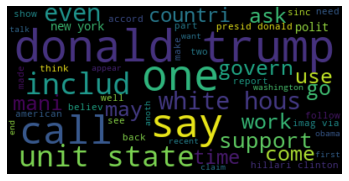

In [74]:
#Swap out with NLTK method for more accurate wordcloud on all data
text_wc_visual_3 = " ".join(text for text in all_df.updated_text)

wordcloud_nltk = WordCloud(contour_color = "pink",max_words = 50).generate(text_wc_visual_3)
#Parameters = WordCloud(width = 500, 
                      #contour_color = "purple",
                      #height= 300, 
                      #random_state = 21,
                      #max_words = 30,
                      #max_font_size =110).generate(top_words)
                    
plt.imshow(wordcloud_nltk, interpolation='bilinear')
plt.axis("off")
plt.show() 

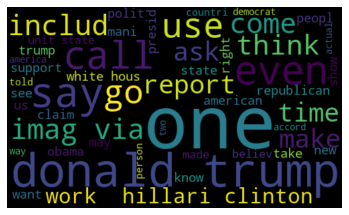

In [75]:
#Swap out with NLTK method for more accurate wordcloud on fake data
text_wc_visual_4 = " ".join(text for text in fake_df.updated_text)

wordcloud_nltk_2 = WordCloud(width = 500, contour_color = "green",
                      height= 300, 
                      random_state = 21,
                      max_words = 50,
                      max_font_size =110).generate(text_wc_visual_4)
                    
plt.imshow(wordcloud_nltk_2, interpolation='bilinear')
plt.axis("off")
plt.show() 

## Method 3: Universal Sentence Encoder
This method will encode text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

In [ ]:
%%capture
!pip3 install seaborn

In [57]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


In [58]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

fake_vectors_use = fake_df['text'].apply(lambda row: pd.Series(embed([row]).numpy()[0])  )

In [59]:
true_vectors_use = true_df['text'].apply(lambda row: pd.Series(embed([row]).numpy()[0])  )

In [60]:
fake_vectors_use['y'] = 0

In [61]:
true_vectors_use['y'] =1

In [62]:
all_use_df = pd.concat([fake_vectors_use, true_vectors_use], ignore_index=True)

In [63]:
all_use_df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,-0.057509,-0.059308,-0.055847,-0.001866,-0.050274,0.022593,-0.059815,0.011298,-0.014126,0.056969,...,-0.059875,0.059863,0.059505,-0.006200,-0.039217,0.035525,0.057870,-0.057940,-0.036608,0
1,-0.019215,0.021323,-0.052237,-0.056360,0.058728,0.038473,-0.008046,-0.038377,0.058357,-0.059912,...,-0.061061,0.038484,-0.021156,-0.019728,-0.023837,0.014232,0.060516,-0.056328,-0.060244,0
2,-0.052525,0.015357,0.020959,0.035746,0.020194,-0.028211,0.034177,-0.006964,-0.061236,-0.060186,...,-0.061299,0.060642,0.045271,-0.013943,-0.031841,0.049962,0.061211,-0.059944,-0.030282,0
3,-0.057734,-0.037952,0.004421,-0.024387,0.037730,0.059065,-0.059985,0.035475,0.038915,-0.036140,...,-0.060256,0.059110,0.055070,-0.046820,-0.035967,-0.049639,0.055697,-0.048528,-0.023438,0
4,-0.037813,-0.017176,-0.010894,0.038072,-0.016722,0.038640,-0.048632,-0.005870,-0.050362,0.001962,...,-0.061967,0.016121,0.022234,-0.061295,0.061488,0.010188,0.057850,-0.027527,-0.045003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,-0.040858,-0.058276,-0.053556,-0.035728,-0.057107,0.052793,0.049031,-0.038300,0.009894,0.042940,...,-0.058400,0.034830,0.008004,-0.055672,-0.058291,0.019649,0.058310,-0.058223,-0.058300,1
44894,-0.034703,-0.025960,-0.009686,0.037063,-0.029287,0.022791,0.000491,-0.031773,0.050054,-0.068951,...,-0.070300,0.007082,0.052345,0.042077,-0.065674,0.012807,0.062687,-0.069922,-0.065057,1
44895,-0.017119,-0.048828,0.023959,-0.032707,-0.034148,0.063706,-0.003588,-0.029912,0.036051,-0.064371,...,-0.065539,0.008821,0.033743,-0.042869,0.025705,-0.049930,0.013773,-0.056989,-0.063729,1
44896,0.037789,-0.003887,-0.057642,-0.056685,0.031717,0.046057,-0.012189,-0.044224,0.057275,0.046016,...,-0.060968,-0.021975,-0.020335,0.006894,0.060977,0.007308,0.055496,-0.060728,-0.060977,1


In [64]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(
                                                            all_use_df.drop(columns=['y']), 
                                                            all_use_df['y'])

### Accuracy of Model

In [66]:
from sklearn.ensemble import RandomForestClassifier

rfc_use = RandomForestClassifier(n_estimators=500, max_depth=2, n_jobs=-1)

rfc_use.fit(X_use_train, y_use_train)

print(rfc_use.score(X_use_train, y_use_train))
print(rfc_use.score(X_use_test, y_use_test))

0.8764885813559825
0.8734966592427617


# Part 3: Facebook Political Ads Classified Into Fake Versus Authentic Via Random Forest Model 

## Part 3: Experiment: Overlay Classifier on Facebook Political Advertisements


### Convert sentences into numeric vectors.
We need to transform sentences into NUMERIC vectors so that the vectors can be included in a Random Forest Classifier model, which cannot use string values.



In [67]:
#Load Facebook data set for NLP analysis, or "fb" data set of messages
fb = pd.read_csv('/storage/fbpac-ads-en-US.csv')
#fb = pd.read_csv("/https://kaggle/input/political-advertisements-from-facebook/fbpac-ads-en-US.csv")
#fb = pd.read_csv(r'C:/Users/mehrunisaqayyum/Downloads/work/fbpac-ads-en-US.csv')
#fb = pd.read_csv(r'C:/Users/mehrunisaqayyum/Downloads/work/fbpac.csv')
#fb = pd.read_csv('/Users/mehrunisaqayyum/Downloads/work/fbpac.csv')
#fb = pd.read_csv('/⁨Users⁩/⁨mehrunisaqayyum⁩/Downloads⁩/work/fbpac-ads-en-US.csv')
#fb = pd.read_csv(r'C:/Users/mehrunisaqayyum/Downloads/fbpac.csv')
#fb = pd.read_csv('/Users/mehrunisaqayyum/Downloads/work/fbpac-ads-en-US.csv')
fb

,id,html,political,not_political,title,message,thumbnail,created_at,updated_at,lang,...,suppressed,targets,advertiser,entities,page,lower_page,targetings,paid_for_by,targetedness,listbuilding_fundraising_proba
0,hyperfeed_story_id_5c9baa3ee0ec08073500042,"<div class=""_5pa- userContentWrapper""><div cla...",0,0,League of Conservation Voters,<p>BREAKING: Trump’s Department of the Interio...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2019-03-27 16:52:25.625455+00,2019-03-27 16:52:25.625455+00,en-US,...,f,[],NaN,"[{""entity"": ""Endangered Species Act"", ""entity_...",https://www.facebook.com/LCVoters/,https://www.facebook.com/lcvoters/,NaN,League of Conservation Voters,NaN,0.647945
1,hyperfeed_story_id_5c9bb2a2413852086735771,"<div class=""_5pa- userContentWrapper""><div cla...",0,0,Indivisible Guide,<p>The Mueller investigation is over. Special ...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2019-03-27 17:28:14.096849+00,2019-03-27 17:28:14.096849+00,en-US,...,f,[],NaN,"[{""entity"": ""Americans"", ""entity_type"": ""Group...",https://www.facebook.com/indivisibleguide/,https://www.facebook.com/indivisibleguide/,NaN,Indivisible Project,NaN,0.350635
2,hyperfeed_story_id_5c9bb4fa461731e29426627,"<div class=""_5pa- userContentWrapper""><div cla...",0,0,International Rescue Committee,<p>Zimbabwe is reeling from the impact of Cycl...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2019-03-27 17:38:23.101377+00,2019-03-27 17:38:23.101377+00,en-US,...,f,[],NaN,"[{""entity"": ""Zimbabwe"", ""entity_type"": ""Region""}]",https://www.facebook.com/InternationalRescueCo...,https://www.facebook.com/internationalrescueco...,NaN,International Rescue Committee,NaN,0.999909
3,23843380741530360,"<div class=""_5pcr userContentWrapper""><div cla...",0,0,Covenant House International,<p>What more can you do in the final hours of ...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2018-12-30 20:59:13.879124+00,2018-12-30 20:59:13.879124+00,en-US,...,f,"[{""target"": ""Activity on the Facebook Family""}...",Covenant House International,[],https://www.facebook.com/CovenantHouse/,https://www.facebook.com/covenanthouse/,"{""<div><div class=\""_4-i0 _26c5\""><div class=\...",Covenant House International,5.0,NaN
4,hyperfeed_story_id_5c9bb059454851c17741213,"<div class=""_5pa- userContentWrapper""><div cla...",0,1,Planned Parenthood,"<p>Say it loud, say it proud: Our rights, our ...",https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2019-03-27 17:18:29.764002+00,2019-04-11 15:02:58.081112+00,en-US,...,f,[],NaN,"[{""entity"": ""Planned Parenthood"", ""entity_type...",https://www.facebook.com/PlannedParenthood/,https://www.facebook.com/plannedparenthood/,NaN,Planned Parenthood Federation of America,NaN,0.999977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,23842830863250097,"<div class=""_1dwg _1w_m""><div><span class=""_47...",1,0,Really American,<p>It's time we called the NRA what they reall...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2018-03-13 03:38:30.678839+00,2018-03-13 07:01:48.847557+00,en-US,...,f,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Really American,"[{""entity"": ""NRA"", ""entity_type"": ""Organizatio...",https://www.facebook.com/reallyamerican/,https://www.facebook.com/reallyamerican/,"{""<div><div class=\""_4-i0 _26c5\""><div class=\...",NaN,4.0,0.238813
1411,6088137902611,"<div class=""_1dwg _1w_m _q7o""><div class=""_4r_...",2,1,The Nature Conservancy,<p>The seeds of change must be planted today. ...,https://pp-facebook-ads.s3.amazonaws.com/v/t1....,2018-01-01 20:08:37.879062+00,2018-01-12 01:58:57.272757+00,en-US,...,f,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",The Nature Conservancy,[],https://www.facebook.com/thenatureconservancy/,https://www.facebook.com/thenatureconservancy/,"{""<div><div class=\""_4-i0 _26c5\""><div class=\...",NaN,3.0,0.999913
1412,23842961798260247,"<div class=""_5pcr userContentWrapper""><div cla...",2,4,Wil

In [68]:
fb.dtypes

id                                 object
html                               object
political                           int64
not_political                       int64
title                              object
message                            object
thumbnail                          object
created_at                         object
updated_at                         object
lang                               object
images                             object
impressions                       float64
political_probability             float64
targeting                          object
suppressed                         object
targets                            object
advertiser                         object
entities                           object
page                               object
lower_page                         object
targetings                         object
paid_for_by                        object
targetedness                      float64
listbuilding_fundraising_proba    

### CLF from Training of fake data sets
#### Predict outcomes for Facebook 
    Y_fb_pred = clf.predict(X_train_fake, Y_train_true).predict(X_test_fb_pol)
Y_fb_pred = clf.predict(X_fb_pol).  #Whole Test Set is FB Dataset

In [69]:
#from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re,string,unicodedata
from nltk.stem import WordNetLemmatizer,PorterStemmer
import os
import gc
from nltk.tokenize import word_tokenize
from collections import  Counter

#stop = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
#stop.update(punctuation)

In [70]:
#should fe include "fb_vectors"?
fe = ['title','message','paid_for_by']
text_fb = fb[fe]
text_fb.head(-10)

,title,message,paid_for_by
0,League of Conservation Voters,<p>BREAKING: Trump’s Department of the Interio...,League of Conservation Voters
1,Indivisible Guide,<p>The Mueller investigation is over. Special ...,Indivisible Project
2,International Rescue Committee,<p>Zimbabwe is reeling from the impact of Cycl...,International Rescue Committee
3,Covenant House International,<p>What more can you do in the final hours of ...,Covenant House International
4,Planned Parenthood,"<p>Say it loud, say it proud: Our rights, our ...",Planned Parenthood Federation of America
...,...,...,...
1400,Alley Cat Allies,<p>Celebrate a cat advocate in your neighborho...,Alley Cat Allies
1401,Donald J. Trump,<p>You’ve seen what liberals have done to try ...,"Donald J. Trump for President, Inc."
1402,Samuel Bagenstos for Justice,<p>No child should have to choose between thei...,"Samuel Bagenstos for Justice, 2370 E. Stadium ..."
1403,Oxfam,<p>You have the power to help rush life-saving...,Oxfam America


#### Sample Facebook Text Data:
For the whole data set, we would need to vectorize Facebook Feature of Interest. However, this is resource intensive. As shown above, it takes over 30 minutes to vectorize both the true and fake data sets to create our model's classifier with over 96 percent accuracy. 


In [ ]:
#Facebook Vectors: Take from: Facebook dataframe 'fb' datafram
#fb_vectors = fb['message'].progress_apply(lambda x: pd.Series(nlp(x).doc.vector.tolist()))

In [71]:
#need values to be strings 
text_fb.dtypes

title          object
message        object
paid_for_by    object
dtype: object

### Text Cleaning
We will review text in columns 'title','message','paid_for_by' for our Natural Language Processing project.

In [72]:
'''Remove punctuation and "weird stuff like --" from ['title','message','paid_for_by'].'''

import re

def text_cleaner(text_fb):
    # Visual inspection identifies a form of punctuation spaCy does not
    text1 = re.sub(r'<.*?>',' ', text_fb) #removes the  pp beginning and end
    text1 = re.sub(r'--',' ',text_fb)  # recognize: the double dash '--'.  Better get rid of it now!
    text1 = re.sub("[\[].*?[\]]", "", text_fb)
    text1 = ' '.join(text_fb.split())
    return text1

#Used above in Part 2 to clean first body of text:
    #text = re.sub('<.*?>', "", text) #Remove html tag
    #pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') #Return leftover urls
    #text = re.sub(pattern, ' ', text) #includes pattern when the urls weren't removed from above

In [73]:
'''clean_text_round2: Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
import re
import string

def clean_text_round2(text1):
    if pd.isna(text1):
        return text1
    
    text2 = text1.lower()
    text2 = re.sub('\[.*?\]', '', text1)
     #Add regex to address the 'p' where removing 'p' with brackets or remove first and last letter
    #text2 = re.sub('\p', ' ', text1)
    text2 = re.sub('\w*\d\w*', '', text1)
    text2 = re.sub('<.*?>', '', text1)
    text2 = re.sub('[%s]' % re.escape(string.punctuation), '', text1)
    text2 = re.sub('<.*?>', '', text1) #should remove 'p' from beginning
    return text2

# <.*?>

In [74]:
#Test a 'message'
clean_text_round2(text_fb['message'].iloc[0])

'BREAKING: Trump’s Department of the Interior plans to remove Endangered Species Act protections for gray wolves. Without these safeguards, gray wolf populations could decline across the country. We must fight back on this attack on our wildlife.'

In [75]:
#Del suggestion to test clean
#Creating new column 'clean_message'

text_fb['clean_message'] = text_fb.message.apply(clean_text_round2)

In [76]:
text_fb #See columns: ['message','clean_message'] that removed 'p'.

,title,message,paid_for_by,clean_message
0,League of Conservation Voters,<p>BREAKING: Trump’s Department of the Interio...,League of Conservation Voters,BREAKING: Trump’s Department of the Interior p...
1,Indivisible Guide,<p>The Mueller investigation is over. Special ...,Indivisible Project,The Mueller investigation is over. Special Cou...
2,International Rescue Committee,<p>Zimbabwe is reeling from the impact of Cycl...,International Rescue Committee,Zimbabwe is reeling from the impact of Cyclone...
3,Covenant House International,<p>What more can you do in the final hours of ...,Covenant House International,What more can you do in the final hours of 201...
4,Planned Parenthood,"<p>Say it loud, say it proud: Our rights, our ...",Planned Parenthood Federation of America,"Say it loud, say it proud: Our rights, our hea..."
...,...,...,...,...
1410,Really American,<p>It's time we called the NRA what they reall...,NaN,It's time we called the NRA what they really a...
1411,The Nature Conservancy,<p>The seeds of change must be planted today. ...,NaN,The seeds of change must be planted today. Bec...
1412,Wilson Center,<p>The U.S. space program has been a source of...,Wilson Center,The U.S. space program has been a source of na...
1413,Gretchen Whitmer,"<p>Bill Schuette doesn’t get it, but I do. It ...",Gretchen Whitmer for Governor,"Bill Schuette doesn’t get it, but I do. It all..."


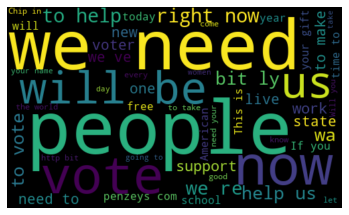

In [77]:
#Use Facebook 'updated_text' label with all text more accurate wordcloud on fake data



text_wc_visual_5 = " ".join(text for text in text_fb.clean_message)

wordcloud_facebook = WordCloud(width = 500, 
                      contour_color = "blue",
                      height= 300, 
                      random_state = 21,
                      max_words = 50,
                      max_font_size =110).generate(text_wc_visual_5)
                    
plt.imshow(wordcloud_facebook, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
#Load selected sample of FB Dataset = From text_fb sample of 200 

your_sample_for_testing = text_fb.sample(n=200, random_state=123)
your_sample_for_testing.to_excel("your_sample_for_testing.xlsx")

In [79]:
#Read data from cleaned sample of 200 records randomly selected in Excel.
df_for_prediction = pd.read_excel('your_sample_for_testing (1).xlsx')

In [80]:
df_for_prediction['message'] = df_for_prediction['message'].str.replace('<.*?>', '').str.lower()

### Vectors Classifier

In [81]:
#Vectorize the sample features from the Excel sample set.
#Need to run in classifier model experiment.
df_for_prediction_vectors = df_for_prediction['message'].apply(lambda x: pd.Series(nlp(x).doc.vector.tolist()))

In [82]:
rfc_vectors.score(df_for_prediction_vectors, df_for_prediction['real_one'])

0.19

#### Note: We see that our experimental model produced a low accuracy score of 18.5 percent. This is below our expectations given that the original classifer developed above in Part 2  achieved a 96 percent accuracy score on the test set. 

### Evaluation Report

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

In [84]:
#X=Expected
#y=Predicted
print(classification_report(df_for_prediction['real_one'], rfc_vectors.predict(df_for_prediction_vectors)))

              precision    recall  f1-score   support

           0       0.08      0.87      0.14        15
           1       0.93      0.14      0.24       185

    accuracy                           0.19       200
   macro avg       0.50      0.50      0.19       200
weighted avg       0.86      0.19      0.23       200



#### Note: Discussion of 'Precision' and 'Recall'. 

In [85]:
#Reviewing Confusion Matrix to check results
#160 items are classified as fake when not really fake. 
#2 items are supposed to be real, but I've misclassified as 'fake'.
#prefer to misclassify as 'fake'.
#Find something 200.

print(confusion_matrix(df_for_prediction['real_one'], rfc_vectors.predict(df_for_prediction_vectors)))

[[ 13   2]
 [160  25]]


### Method 2 Bag of Words Classifier

In [86]:
#Check with Tiago
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
bag_of_words_fb_sample = vectorizer_fake_real.transform(df_for_prediction['message'])

In [87]:
bag_of_words_fb_sample

<200x59063 sparse matrix of type '<class 'numpy.int64'>'
	with 4270 stored elements in Compressed Sparse Row format>

In [88]:
len(rfc_bag.feature_importances_)

59063

In [89]:
#Replace RFC Method. 
    #Swap out first argument for actual messages, not vectors. Keep second argument b/c that's what is what we're comparing. 
    #rfc_vectors.score(df_for_prediction_vectors, df_for_prediction['real_one'])

#rfc_bag.score(df_for_prediction['message'], (df_for_prediction['real_one'])
              
#Tech Support

#rfc_bag.score(df_for_prediction['message'], df_for_prediction['real_one'])
rfc_bag.score(bag_of_words_fb_sample, df_for_prediction['real_one'])

0.095

### Method 3: Universal Sentence Encoder (USE) for Facebook Messages

In [90]:
#Needs FB string messages as vectors
fb_vectors_use = df_for_prediction['message'].apply(lambda row: pd.Series(embed([row]).numpy()[0])  )

In [91]:
rfc_use.score(fb_vectors_use, df_for_prediction['real_one'])

0.12

In [92]:
df_for_prediction['message']

0      our olympic coast has been protected for decad...
1      every day a forest the size of atlanta is clea...
2      hoover institution distinguished research fell...
3      this final video makes the case for why kaleem...
4      raw, wild, texas rescue honey. yum. ==&gt; thi...
                             ...                        
195    do you care? every day, our planet gets closer...
196    protect wildlife by symbolically adopting your...
197    juan castillo pérez leaves dogs to hang from w...
198    tyt is grassroots journalism at its finest: an...
199    "the national democratic redistricting committ...
Name: message, Length: 200, dtype: object

### Top Fifty Words


In [93]:
#Identify top 50 words in Facebook Messages 'text_fb'
f = Counter()

#ignore_this = all_df['updated_text'].apply(lambda row: c.update(row.split(" ")))
ignore_this2 = text_fb['clean_message'].apply(lambda row: f.update(row.split(" ")))

In [139]:
top_words_fb = f.most_common(50)
top_words_fb

[('to', 2764),
 ('the', 2620),
 ('and', 1895),
 ('a', 1290),
 ('of', 1286),
 ('for', 1176),
 ('in', 1112),
 ('is', 915),
 ('our', 837),
 ('you', 756),
 ('your', 735),
 ('on', 593),
 ('that', 546),
 ('', 545),
 ('are', 514),
 ('we', 510),
 ('this', 468),
 ('with', 429),
 ('be', 394),
 ('will', 382),
 ('from', 333),
 ('have', 328),
 ('by', 318),
 ('I', 310),
 ('can', 280),
 ('their', 273),
 ('at', 270),
 ('We', 267),
 ('The', 261),
 ('need', 248),
 ('us', 240),
 ('it', 236),
 ('help', 223),
 ('who', 222),
 ('as', 217),
 ('more', 213),
 ('an', 207),
 ('up', 207),
 ('has', 205),
 ('they', 202),
 ('now', 199),
 ('all', 196),
 ('people', 194),
 ('but', 188),
 ('not', 185),
 ('just', 178),
 ('make', 177),
 ('or', 175),
 ('so', 174),
 ('about', 172)]

### WordCloud: Facebook Political Ad (Messages)
Reviewing top 50 words in messages.

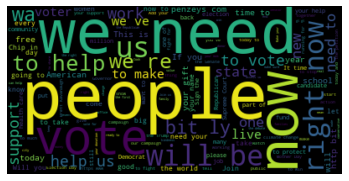

In [98]:
# Create and generate a word cloud image: wordcloud = WordCloud().generate(text)
#text_wc_visual2 = " ".join(text for text in text_fb.clean_text)
top_words_fb = " ".join(text for text in text_fb['clean_'])

wordcloud_BOW2 = WordCloud().generate(top_words_fb) #(text_wc_visual2)
#wordcloud_BOW = WordCloud(width = 500, 
                      #contour_color = "purple",
                      #height= 300, 
                      #random_state = 21,
                      #max_words = 30,
                      #max_font_size =110).generate(top_words)
                    
plt.imshow(wordcloud_BOW2, interpolation='bilinear')
plt.axis("off")
plt.show() 

## Part 4: Conclusion and Future Exploration: 
### Sentiment Analysis
Source: https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/3-Sentiment-Analysis.ipynb Regarding text data, there are a few popular techniques that we'll be going through in the next few notebooks, starting with sentiment analysis. A few key points to note with sentiment analysis.

TextBlob Module: Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels. Sentiment Labels: Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these. Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive. Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion. For more info on how TextBlob coded up its sentiment function.